- Adapt the code for pretrained nets to work with Resnet50

# Load libraries

## Pretrained nets

https://keras.io/applications/

In [15]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

# image processing
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import img_to_array

# pretrained nets
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
train_image_files_path = "/keras2production/fruits/Training/"
valid_image_files_path = "/keras2production/fruits/Test/"

In [7]:
model = ResNet50(weights='imagenet')

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [12]:
def classify_image(image):
    img = cv2.imread(image)        
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    # images need to be numpy arrays of 224 x 224 color images with 3 channels
    image = image_utils.load_img(image, target_size=(224, 224))
    image = image_utils.img_to_array(image)

    # expand the dimensions to be (1, 3, 224, 224)
    image = np.expand_dims(image, axis=0)

    # scale pixels between -1 and 1, sample-wise
    image = preprocess_input(image)
        
    preds = model.predict(image)
    res = decode_predictions(preds, top=3)
    
    for (i, (imagenetID, label, prob)) in enumerate(res[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

In [20]:
train_images = !find $train_image_files_path/Banana -type f -name "*.jpg"

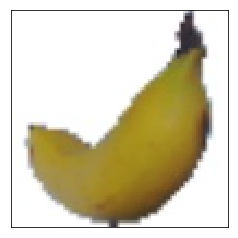

1. banana: 44.87%
2. Arabian_camel: 15.65%
3. punching_bag: 6.06%


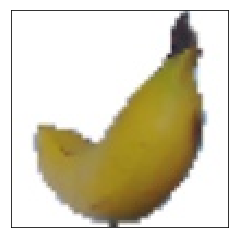

1. banana: 28.67%
2. rock_beauty: 7.60%
3. punching_bag: 6.66%


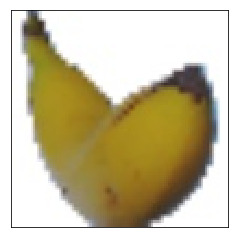

1. punching_bag: 11.34%
2. chain_saw: 8.91%
3. safety_pin: 5.46%


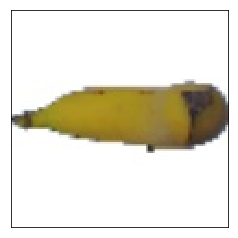

1. projectile: 27.66%
2. wine_bottle: 26.04%
3. missile: 9.77%


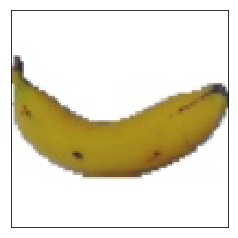

1. banana: 99.25%
2. hook: 0.30%
3. spaghetti_squash: 0.13%


In [22]:
num = 5
train_images_r = random.sample(train_images, num)
for i in range(num):
    classify_image(train_images_r[i])

In [23]:
train_images_r

['/keras2production/fruits/Training//Banana/286_100.jpg',
 '/keras2production/fruits/Training//Banana/7_100.jpg',
 '/keras2production/fruits/Training//Banana/151_100.jpg',
 '/keras2production/fruits/Training//Banana/r_81_100.jpg',
 '/keras2production/fruits/Training//Banana/122_100.jpg']

In [25]:
img = image_utils.load_img(train_images_r[1], target_size=(224, 224))
# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image_utils.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n07753592', 'banana', 0.28672644), ('n02606052', 'rock_beauty', 0.075977445), ('n04023962', 'punching_bag', 0.06659809)]


In [27]:
banana_output = model.output[:, np.argmax(preds[0])]
banana_output

<tf.Tensor 'strided_slice:0' shape=(?,) dtype=float32>

In [28]:
# The is the output feature map of the `res5c_branch2c` layer,
# the last convolutional layer in ResNet50
last_conv_layer = model.get_layer('res5c_branch2c')

In [29]:
# This is the gradient of the class with regard to
# the output feature map of `res5c_branch2c`
grads = K.gradients(banana_output, last_conv_layer.output)[0]

In [30]:
# This is a vector where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [31]:
# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `res5c_branch2c`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [33]:
# These are the values of these two quantities, as Numpy arrays,
# given our sample image 
pooled_grads_value, conv_layer_output_value = iterate([x])

In [36]:
# We multiply each channel in the feature map array
# by "how important this channel is" 
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [37]:
# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap.shape

(7, 7)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


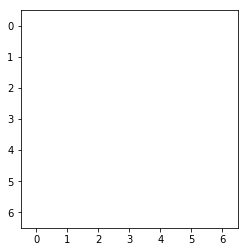

In [38]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.mean(heatmap)
heatmap = np.uint8(heatmap * -0.6)
plt.imshow(heatmap, cmap="Greys")
plt.show()